In [398]:
#need to install to import and call LGBMClassifier
!pip install lightgbm

In [396]:
#need to install to import and call XGBClassifier
!pip install xgboost

In [515]:
import pandas as pd
import numpy as np
import re #regular expressions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #scales data
from sklearn.preprocessing import LabelEncoder  #converts strings to integers by encoding
from sklearn.feature_selection import SelectFromModel  #reduces features to be train on based on importance to reduce noise,
# model scores:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# hyperameters 
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# samplers
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
#models: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier




In [516]:
#read in the CSV
df = pd.read_csv('incident_event_log.csv')

In [ ]:
#at first glance it looks like there are no missing values however we know they use ? inplace of NaN values
df.info()

In [518]:
#change all ? marks to NAN values so we can manipulate them easier
df_nan = df.copy()
df_nan = df.replace('?',np.nan)

In [ ]:
#Now we can see the columns with missing values
df_nan.info()

In [519]:
#changing all objects to datetime values in the date columns
df_nan['opened_at']= pd.to_datetime(df_nan['opened_at'],dayfirst= True)
df_nan['resolved_at'] = pd.to_datetime(df_nan['resolved_at'], dayfirst = True)
df_nan['closed_at'] = pd.to_datetime(df_nan['closed_at'],dayfirst = True)
df_nan['sys_created_at'] = pd.to_datetime(df_nan['sys_created_at'],dayfirst = True)


In [659]:
# creating a difference column to show the amount of days it takes to resolve a ticket that will be used for the target column
df_nan['difference'] = (df_nan['resolved_at'] - df_nan['opened_at']).dt.days
#checking to see the time in days it takes from resolving a ticket and closing a ticket
df_nan['resolved_closed_diff'] = (df_nan['closed_at'] - df_nan['resolved_at']).dt.days

In [660]:
#looking at the distrabution of days it takes to close a ticket after its been resolved
df_nan.value_counts('resolved_closed_diff')

resolved_closed_diff
5.0     117907
7.0       2999
6.0       2144
10.0      1904
15.0      1842
         ...  
49.0         2
56.0         2
57.0         2
63.0         2
38.0         2
Name: count, Length: 68, dtype: int64

Below are mutiple versions for a target column using the difference between the columns opened_at and resolved at. The target column gives us a binary output depending on the difference between these columns and then deciding the cut off point for our zero and ones. We have decided to use 2 days as our cut off point, but have not yet tested the other target columns for our Y value in the models.

In [521]:
#creates a target column of 0s and 1s based on the amount of days it took to resolve the incident.
#if the amount of days is greater than 2 or NAN it turns to 1 and if 2 or below it is a 0
df_nan['target_colum'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 2 else 0, axis = 1)

#One day target column
df_nan['one_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 1 else 0, axis = 1)

#three day target column
df_nan['three_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 3 else 0, axis = 1)

#four day target column
df_nan['four_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 4 else 0, axis = 1)

#five day target column
df_nan['five_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 5 else 0, axis = 1)

#6 day target column
df_nan['six_day_solve'] = df_nan.apply(lambda row: 1 if pd.isna(row['resolved_at'])
                                       or (row['resolved_at'] - row['opened_at']).days > 6 else 0, axis = 1)

In [629]:
df_nan.value_counts('one_day_solve')

one_day_solve
1    81257
0    60455
Name: count, dtype: int64

In [523]:

#creating another option for target column using the time the ticket was closed instead of solved
df_nan['target_closed'] = df_nan.apply(lambda row: 1 if (row['closed_at'] - row['opened_at']).days > 2 else 0, axis = 1)
# looks way to unbalanced, not a good idea
df_nan.value_counts('target_closed')

target_closed
1    141312
0       400
Name: count, dtype: int64

In [524]:
#shows a balanced target column for the 2 day target values
df_nan.value_counts('target_colum')

target_colum
1    73232
0    68480
Name: count, dtype: int64

In [662]:
# Creating a function to prioritize 'new' and 'active' incident states that will emliminate duplicate incident numbers
"""Parmerter: takes grouped data frame and applys to each group of data
returns a data frame that only includes one instance of every value in the 'number' column
that has a correlating 'incident_state' value of 'New' if possible and then filters to 'active', 
while also including one instance of a 'number' that does not have new or active in 'incident_state'
Returns filtered data frame"""
def new_active_incident_state(group):
    if (group['incident_state'] == 'New').any():
        return group[group['incident_state'] == 'New'].iloc[0]
    elif (group['incident_state'] == 'Active').any():
        return group[group['incident_state'] == 'Active'].iloc[0]
    else:
        return group.iloc[0]  # In case neither 'new' nor 'active' exists, retain the first occurrence

# Apply this function to the DataFrame by grouping by 'number'
df_new_active = df_nan.groupby('number',group_keys=False).apply(new_active_incident_state).reset_index(drop=True)
# View the result
#df_new_active

###warning note: group_keys = Flase is not yet apart of pandas and thus will not work, however by including group_keys = False exlcudes the 'number' column form being included in the apply results and should avoid altering the sturcture of the result


C:\Users\tyzwh\AppData\Local\Temp\ipykernel_988\1345615283.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new_active = df_nan.groupby('number',group_keys=False).apply(new_active_incident_state).reset_index(drop=True)


In [680]:
display(df_new_active.value_counts('one_day_solve')) #1 day target balance
display(df_new_active.value_counts('target_colum')) #2 day resolve target
display(df_new_active.value_counts('three_day_solve')) #3 day target balance
display(df_new_active.value_counts('four_day_solve')) #4 day target balance
display(df_new_active.value_counts('five_day_solve')) #5 day target balance
display(df_new_active.value_counts('six_day_solve')) #6 day target balance

one_day_solve
0    13905
1    11013
Name: count, dtype: int64

target_colum
0    15095
1     9823
Name: count, dtype: int64

three_day_solve
0    15951
1     8967
Name: count, dtype: int64

four_day_solve
0    16619
1     8299
Name: count, dtype: int64

five_day_solve
0    17282
1     7636
Name: count, dtype: int64

six_day_solve
0    18001
1     6917
Name: count, dtype: int64

In [691]:
#This shows us that made_sla changes value after the ticket is initially created
df_new_active.value_counts('made_sla')

made_sla
True     24917
False        1
Name: count, dtype: int64

In [677]:

# Creating a function to prioritize 'made_sla' and capture all the unique False values from the number column first and then filling with left over unique True values
def made_sla_false(group):
    """using the same concept from the function new_active_state but instead uses Made_sla to filter
    Parmerter: takes grouped data frame and applys to each group of data
returns a data frame that only includes one instance of every value in the 'number' column
that has a correlating 'made_sla' value of 'False' if possible and then filters to 'True', 
Returns: filtered data frame
    """
    if (group['made_sla'] == False).any():
        return group[group['made_sla'] == False].iloc[0]
    else:
        return group.iloc[0]
    
#apply function to daframe with groupby
df_made_sla_false = df_nan.groupby('number', group_keys=False).apply(made_sla_false).reset_index(drop = True)

#looking at the relationship bewteen made_sla and the target_column
display(df_made_sla_false.value_counts('target_colum'))
display(df_made_sla_false.value_counts('made_sla'))

C:\Users\tyzwh\AppData\Local\Temp\ipykernel_988\1078030334.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_made_sla_false = df_nan.groupby('number', group_keys=False).apply(made_sla_false).reset_index(drop = True)


target_colum
0    15095
1     9823
Name: count, dtype: int64

made_sla
True     15803
False     9115
Name: count, dtype: int64

In [692]:
#allows me to check if the values are same column by column
# This has shown me that opened_at has the same values, but resolved at does not needs further investigation 
if (df_new_active['resolved_at'] == df_made_sla_false['resolved_at']).all():
    print('Match!')
else:
    print('Nope')

Nope


NaN values: If any of the values are NaN in either of the DataFrames, the comparison will return False because NaN == NaN is False.
This is causing the above code to print Nope even though the values actually do match for my purposes

In [707]:
#group by 'number' and filter for groups where the 'difference' values are not the same
different_values_df = df_nan.groupby('number').filter(lambda x: x['difference'].nunique() > 1)

#display the new DataFrame with numbers that have different 'difference' values
different_values_df


,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum,target_closed,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,resolved_closed_diff


The above cell produces an empty dataframe proving that resolved_at does not have different values depending on which unique row based on the 'number' column

In [695]:
#allows me to check if the values are same column by column between 2 different dataframes filtered to unique tickets
#this shows me that even though the resolved_at doesnt match, the target column does, thus we will move forward with our filtered df_new_active dataframe
if (df_new_active['target_colum'] == df_made_sla_false['target_colum']).all():
    print('Match!')
else:
    print('Nope')

Match!


In [678]:
#looking at the distrabution of days it takes to close a ticket after its been resolved
#going to investigate the possible outlier for the difference of 243
df_new_active.value_counts('resolved_closed_diff')

resolved_closed_diff
5.0      20134
7.0        419
6.0        322
10.0       303
15.0       281
         ...  
44.0         1
48.0         1
57.0         1
56.0         1
243.0        1
Name: count, Length: 68, dtype: int64

In [670]:
#shows all the columns without condensing the dataframe with ...
pd.set_option('display.max_columns', None)
#looking at a specific incident ticket that has the largest difference between resolved_at and closed_at 
df_new_active.loc[df_new_active['resolved_closed_diff'] == 243]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum,target_closed,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,resolved_closed_diff
13953,INC0020336,New,True,0,0,0,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 370,18/4/2016 11:07,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0


In [671]:
#looking at the orginal dataframe to see all the instances for the same ticket number with the long delay in close time after being resolved
df_nan.loc[df_nan['resolved_closed_diff'] == 243]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum,target_closed,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,resolved_closed_diff
84918,INC0020336,New,True,0,0,0,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 370,18/4/2016 11:07,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0
84919,INC0020336,New,True,0,0,1,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 370,18/4/2016 11:08,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0
84920,INC0020336,New,True,1,0,3,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 60,18/4/2016 15:56,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0
84921,INC0020336,Resolved,True,1,0,4,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 748,18/4/2016 16:03,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0
84922,INC0020336,Closed,False,1,0,5,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 908,23/4/2016 16:07,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0
84923,INC0020336,Closed,False,1,0,6,True,Caller 145,NaN,2016-04-18 11:05:00,Created by 89,2016-04-18 11:07:00,Updated by 40,18/12/2016 11:42,Phone,Location 108,Category 42,Subcategory 223,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 39,Resolver 194,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 177,2016-04-18 16:03:00,2016-12-18 11:42:00,0.0,0,1,0,0,0,0,0,243.0


In [690]:
#looking at the values in priority which is calculated by the system based on 'impact' and 'urgency';
display(df_new_active['priority'])
display(df_new_active.value_counts('priority'))

0        3 - Moderate
1        3 - Moderate
2        3 - Moderate
3        3 - Moderate
4        3 - Moderate
             ...     
24913    3 - Moderate
24914         4 - Low
24915    3 - Moderate
24916    3 - Moderate
24917    3 - Moderate
Name: priority, Length: 24918, dtype: object

priority
3 - Moderate    23681
4 - Low           741
2 - High          311
1 - Critical      185
Name: count, dtype: int64

In [713]:
#group by 'number' and filter for groups where the 'priority' values are not the same
different_priority_df = df_nan.groupby('number').filter(lambda x: x['priority'].nunique() > 1)

#display the new DataFrame with numbers that have different 'priority' values
display(different_priority_df[['number', 'priority']].head(25))
display(different_priority_df[['number', 'priority']].tail(50))



,number,priority
24,INC0000062,3 - Moderate
25,INC0000062,2 - High
26,INC0000062,2 - High
27,INC0000062,2 - High
28,INC0000062,2 - High
29,INC0000062,2 - High
30,INC0000062,2 - High
31,INC0000062,2 - High
224,INC0000104,3 - Moderate
225,INC0000104,2 - High


,number,priority
141067,INC0104905,1 - Critical
141068,INC0104905,1 - Critical
141069,INC0104905,1 - Critical
141070,INC0104905,1 - Critical
141227,INC0108640,3 - Moderate
141228,INC0108640,3 - Moderate
141229,INC0108640,3 - Moderate
141230,INC0108640,3 - Moderate
141231,INC0108640,3 - Moderate
141232,INC0108640,3 - Moderate


The cells above have shown me that priority does change over the duration of the tickets entries, however it seems that they all at least start with moderate, which shows that my df_new_active has mostly captured the initial tikcket with the moderate rating. however I need to investigate the tickets that I have captured that don't have a moderate rating? Are they not the first instance of the ticekt,


My current model does not use the rating columns in its featrue selection, and these findings validates that choice.

In [715]:
print(df_new_active['priority'].unique())

['3 - Moderate' '4 - Low' '1 - Critical' '2 - High']


In [716]:
#creating dataframe that captures all the critical and priority tickets to see their target column results from the filtered df
df_critical_high = df_new_active[(df_new_active['priority'] == '1 - Critical') | (df_new_active['priority'] == '2 - High')]
df_critical_high.value_counts('target_colum')

target_colum
0    274
1    222
Name: count, dtype: int64

In [723]:
df_critical_high[['number']].head(5)

,number
111,INC0000261
173,INC0000370
200,INC0000433
224,INC0000508
231,INC0000517


In [721]:
#lets look at the orginal dataframe with one of the 'number' values below to make sure we are capturing the first priority value for a given number
df_nan.loc[df_nan['number'] == 'INC0000433']

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum,target_closed,one_day_solve,three_day_solve,four_day_solve,five_day_solve,six_day_solve,resolved_closed_diff
1285,INC0000433,New,True,0,0,0,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 578,29/2/2016 20:58,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1286,INC0000433,New,True,0,0,1,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 111,29/2/2016 21:40,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1287,INC0000433,New,True,0,0,2,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 578,29/2/2016 22:16,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1288,INC0000433,New,True,0,0,5,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 432,8/3/2016 16:43,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1289,INC0000433,New,True,0,0,6,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 432,8/3/2016 17:18,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1290,INC0000433,Active,True,0,0,7,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 432,8/3/2016 17:39,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,False,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1291,INC0000433,Resolved,True,0,0,8,True,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 578,25/3/2016 23:57,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,True,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0
1292,INC0000433,Closed,False,0,0,9,False,Caller 2692,Opened by 305,2016-02-29 20:32:00,Created by 130,2016-02-29 20:58:00,Updated by 908,30/3/2016 23:59,Phone,Location 143,Category 19,Subcategory 289,Symptom 117,NaN,1 - High,1 - High,1 - Critical,Group 61,Resolver 165,True,True,Do Not Notify,Problem ID 23,NaN,NaN,NaN,code 7,Resolved by 134,2016-03-25 23:57:00,2016-03-30 23:59:00,25.0,1,1,1,1,1,1,1,5.0


The tickets with critical and high values in the priority column do seem to be initial imputs from when the ticket was made, thus we will keep these in the training set. however as you can see even with higher values, these tickets still have a balanced target column thus won't help the model predict.

In [526]:
#This shows that our filtered dataFrame retains all of the unique values in the 'number' column
duplicates_list = df_nan['number'].unique().tolist()
display(len(duplicates_list))
unique_list_check = df_new_active['number'].unique().tolist()
display(len(unique_list_check))

24918

24918

In [527]:
#this shows that we have a slightly imbalanced data set with 2x as many trues than falses, will probably have to use sampler
df_new_active['target_colum'].value_counts()

target_colum
0    15095
1     9823
Name: count, dtype: int64

In [207]:
#shows the total 8 possible values for filtering compared to the output of our filtered data frame
display(df_nan.value_counts('incident_state'))
display(df_new_active.value_counts('incident_state'))


incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: count, dtype: int64

incident_state
New                   16397
Active                 6566
Resolved               1816
Awaiting User Info      133
Awaiting Problem          6
Name: count, dtype: int64

**Who are we presenting too:** ServiceNow Research and Development ITSM department

#### Target **complete
* create target column: numbers of days ticket is open???
* what could this tell us, or how could we explain this as usefull: if we can succesfully predict whether an incident will be resolved in sufficent time given info porovided about the incident. Then we could advise...???
* who wants this?

#### TO DO List
* **complete** figure out how to filter to find all duplicate incedents for same value in 'number' and only retain 1 incedence set to 'incident_status == 'new'
* **complete**create repository and seperate branches  link: https://github.com/Sug-ar-N-Spice/Incident_Events.git
* **complete**turn all ? into NANs
* **complete**find documentation/info of columns   link: https://archive.ics.uci.edu/dataset/498/incident+management+process+enriched+event+log
* **semi-complete**create target column: complete for tickets open over 2 days
* **complete** decide if there are any columns we can get drop ..ex.'number'
* **complete** also decide what columns would cuase dataleaks to give the model all the answers renderring our model useless..ex. time/date, days open, other columns?
* **complete**Parameter loops

* decide if the target column is relavant enough for conclusion
* do we need fucntions? because this is our only dataset, we don't have another one to test?
* DO we need a standard scaler( don't need it)
* DO we need PCA to reduce the columns?
* Do we need resampler(need it)
* clustering? dont we need it for certain models? #original task is regresion and clustering should we do this to understand data

**curenlty working on:**
* **complete** list all columns with NaN values
* find the NANS and figure out how to fill
* replace strings with numbers
* list out the models that we will attempt to use find code examples/syntax ready
* Find other versions of random forest classifire 
* Try to look up code references, but randomforestclassfier might be able to overcome and just keep code numbers
  

In [63]:
df_nan.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'difference', 'target_colum'],
      dtype='object')

## create a data frame with the following columns for training
#List of columns to keep for Training set:
* opened_by: identifier of the user who reported the incident
* opened_at: incident user opening date and time
* contact_type: categorical attribute that shows by what means the incident was reported
* location: identifier of the location of the place affected
* category: first-level description of the affected service
* subcategory: second-level description of the affected service (related to the first level description, i.e., to category);
* u_symptom: description of the user perception about service availability
* impact: description of the impact caused by the incident (values: 1â€“High; 2â€“Medium; 3â€“Low);
* urgency: description of the urgency informed by the user for the incident resolution (values: 1â€“High; 2â€“Medium; 3â€“Low);
* priority: calculated by the system based on 'impact' and 'urgency';
* assignment_group: identifier of the support group in charge of the incident;
* assigned_to: identifier of the user in charge of the incident;
* knowledge: boolean attribute that shows whether a knowledge base document was used to resolve the incident;
* u_priority_confirmation: boolean attribute that shows whether the priority field has been double-checked;
* notify: categorical attribute that shows whether notifications were generated for the incident;

### Too many missing values? (re-evalue to possibly fill and add back in)
* rfc: (98 entries)(request for change) identifier of the change request associated with the incident;
* cmdb_ci: (only has 51 entries) (confirmation item) identifier used to report the affected item (not mandatory)
* vendor:(probably drop only 15 entries) identifier of the vendor in charge of the incident;
* caused_by:(drop only 2 entires) identifier of the RFC responsible by the incident
* problem_id:(241 entries) identifier of the problem associated with the incident;
*  sys_created_by: identifier of the user who registered the incident
* sys_created_at: incident system creation date and time


list of potential:exclude these columns
* sys_updated_by:(? is this generated day 1?) identifier of the user who updated the incident and generated the current log record
* sys_updated_at:(?day 1 info?) incident system update date and time


## list of columns not used in training set
number, incident_state, active, reassignment_count, reopen_count, sys_mod_count, made_sla, caller_id,
sys_created_by, sys_created_at, sys_updated_by, sys_updated_at, closed_code, resolved_by, resolved_at, closed_at

|header  |  |
|--|--|
| values |  |

In [208]:
df_caused_by = df_new_active[df_new_active['caused_by'].notna()]
df_caused_by

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,difference,target_colum
186,INC0000388,New,True,0,0,0,True,Caller 2020,Opened by 221,2016-02-29 16:43:00,...,Problem ID 17,CHG0000132,NaN,CHG0000132,code 7,Resolved by 197,2016-03-22 16:47:00,2016-03-27 16:59:00,22.0,1
663,INC0001131,New,True,0,0,0,True,Caller 93,Opened by 40,2016-03-02 10:41:00,...,Problem ID 8,CHG0000097,NaN,CHG0000097,code 6,Resolved by 197,2016-03-22 16:38:00,2016-03-27 16:59:00,20.0,1


### Filling missing NANs:
*sys_created_at and sys_created_by have the same missing values(took out of training data frame) check passes and fails count, dont know if this is day one info because the time is past the opened_at time???
### Converting strings into numbers: list to convert
**complete**
### converted dates
* opened_at (seperate into 2 or 3 columns) No Nan values: seperated into 3 columns, day of week, month, year
### filled with grab_number_last
* opened_by (714 NaNs)
* location (51 NaNs)
* category (39 NaNs)
* subcategory
* u_symptom
* assignment_group
* assigned_to
* problem_id (241 entries) exfill_df
* cmdb_ci (51 entries) exfill_df
* caller Id (not in inital model tests)
### columns filled with grab_1rst_num
* urgency
* priority
* impact
### Filled w/ onehot_bool
*knowledge
u_priority_confirmation
### Filled with get_dummies
* contact_type
* notify
### filled w/ extract_end_numbers
* caused_by (2 entries): exfill_df
* rfc (98 entries): exfill_df 
### filled with vendor
* vendor (15 entries) fill with 1s, 8s and -1


#### original columns with NAN
['caller_id', 'opened_by','sys_created_by','sys_created_at','location','category','subcategory',
 'u_symptom','cmdb_ci','assignment_group','assigned_to','problem_id','rfc','vendor','caused_by',
 'closed_code','resolved_by','resolved_at','difference']

In [727]:
#checking for NaNs
df_new_active['priority'].isnull().sum()


0

In [728]:
#find the percentage of null values in each column
df_nan.isna().sum()/len(df_nan)

number                     0.000000
incident_state             0.000000
active                     0.000000
reassignment_count         0.000000
reopen_count               0.000000
sys_mod_count              0.000000
made_sla                   0.000000
caller_id                  0.000205
opened_by                  0.034118
opened_at                  0.000000
sys_created_by             0.374534
sys_created_at             0.374534
sys_updated_by             0.000000
sys_updated_at             0.000000
contact_type               0.000000
location                   0.000536
category                   0.000550
subcategory                0.000783
u_symptom                  0.232613
cmdb_ci                    0.996860
impact                     0.000000
urgency                    0.000000
priority                   0.000000
assignment_group           0.100295
assigned_to                0.194027
knowledge                  0.000000
u_priority_confirmation    0.000000
notify                     0

In [528]:
#creating a dataframe that contains all the relvant columns with large sums of missing data
exfill_df = df_new_active[['rfc', 'cmdb_ci', 'vendor', 'caused_by', 'problem_id']].copy()

In [529]:
def extract_end_numbers(value):
    """ Parameters:column of values that need to be cleaned by taking the ending of a string to only capture the number values
    returns: -1 for nan values and int based on the ending of the string value
    call the function: df['column'] = df[column].apply(extract_end_numbers)"""

    if pd.isna(value): #checks if the value is a NaN value
        return int(-1) #Returns -1 if NaN value
    return int(re.search(r'(\d+)$', value).group()) #returns the end of string that contains numbers and turns to integer

#call the function with the specified columns to replace with new int values
exfill_df['rfc'] = exfill_df['rfc'].apply(extract_end_numbers)
exfill_df['caused_by'] = exfill_df['caused_by'].apply(extract_end_numbers)



In [530]:

df_split_dates = df_new_active.copy()
# Extract different components
df_split_dates ['year'] = df_new_active['opened_at'].dt.year
df_split_dates['month'] = df_new_active['opened_at'].dt.month
df_split_dates['day'] = df_new_active['opened_at'].dt.day
df_split_dates['hour'] = df_new_active['opened_at'].dt.hour
df_split_dates['minute'] = df_new_active['opened_at'].dt.minute
df_split_dates['day_of_week'] = df_new_active['opened_at'].dt.dayofweek  # Monday=0, Sunday=6

In [426]:
#selecting the rows to use for training column that only include columns without significant amount of NaN values
train_df = df_split_dates[['caller_id','year', 'month','day_of_week','opened_by', 'contact_type','location',
                                'category', 'subcategory','u_symptom','impact','urgency', 'priority',
                                'assignment_group','assigned_to','knowledge', 'u_priority_confirmation', 'notify',
                                    ]]
train_df.tail()

,caller_id,year,month,day_of_week,opened_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify
24913,Caller 90,2017,2,2,Opened by 8,Email,Location 188,Category 52,Subcategory 177,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 64,Resolver 6,False,False,Do Not Notify
24914,Caller 1899,2017,2,2,Opened by 508,IVR,Location 246,Category 50,Subcategory 10,Symptom 533,3 - Low,2 - Medium,4 - Low,Group 70,NaN,False,False,Do Not Notify
24915,Caller 323,2017,2,2,Opened by 14,Phone,Location 135,Category 59,Subcategory 210,Symptom 483,2 - Medium,2 - Medium,3 - Moderate,Group 73,NaN,False,False,Do Not Notify
24916,Caller 116,2017,2,3,Opened by 12,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify
24917,Caller 116,2017,2,3,Opened by 12,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 10,False,False,Do Not Notify


In [531]:
def grab_number_last(value):
    """parameter: value enter in a column from the data frame where you want to capture the last string and convert to number
    by converting all values to string, splitting them, and then only capturing the last string
     
    Retruns: last string and if NaN returns -1
      
    call: convert the column using df.loc[:,"column_name"] = df["column_name"].apply(grab_number_3rd).astype(int)
    This avoids warnings and converts to an integer"""
    
    
    if pd.isna(value):
        return -1  # converts NaN values to -1
    return str(value).split(" ")[-1]  # splits the string and then captures the last value 


# apply the function to the desired column and convert the result to integers
#use the loc function to specify the column being converted to avoid warnings of working on slice of dataframe
train_df.loc[:, 'opened_by'] = train_df['opened_by'].apply(grab_number_last).astype(int)
train_df.loc[:, 'location'] = train_df['location'].apply(grab_number_last).astype(int)
train_df.loc[:, 'category'] = train_df['category'].apply(grab_number_last).astype(int)
train_df.loc[:, 'subcategory'] = train_df['subcategory'].apply(grab_number_last).astype(int)
train_df.loc[:, 'u_symptom'] = train_df['u_symptom'].apply(grab_number_last).astype(int)
train_df.loc[:, 'assignment_group'] = train_df['assignment_group'].apply(grab_number_last).astype(int)
train_df.loc[:, 'assigned_to'] = train_df['assigned_to'].apply(grab_number_last).astype(int)
exfill_df.loc[:, 'problem_id'] = exfill_df['problem_id'].apply(grab_number_last).astype(int)
train_df.loc[:, 'caller_id'] = train_df['caller_id'].apply(grab_number_last).astype(int)
exfill_df.loc[:, 'cmdb_ci'] = exfill_df['cmdb_ci'].apply(grab_number_last).astype(int)



In [532]:
def grab_1rst_num(value):
    """ parameter: column with values that need to be split and capture the first part of the string, which can be converted to integer
    returns: dataframe with splits need to replace orginal column when you call the function
    call: df.loc[:,'column'] = df[column].apply(grab_1rst_num).astype(int) #this will avoid warnings but outputs objects
    alternate call: df['column'] = df['column].apply(grab_1rst_num).astype(int) #gives warning for working on slice"""
    if (value):
        return str(value).split(" ")[0] #grabs the 1rst part of the string that can be converted to an integer

train_df.loc[:,'urgency'] = train_df['urgency'].apply(grab_1rst_num).astype(int)
train_df.loc[:,'impact'] = train_df['impact'].apply(grab_1rst_num).astype(int)
train_df.loc[:,'priority'] = train_df['priority'].apply(grab_1rst_num).astype(int)






In [533]:
def vendor(value):
    """parameters:only works on vendor column, manually changes 'Vendor 1' value to 1, 'code 8' to 8 and NaNs to -1 
    Returns: fills with 1, 8, and -1
    call: exfill_df['vendor'] = exfill_df['vendor'].apply(vendor)"""
    if value == 'Vendor 1':
        return int(1)
    elif value == 'code 8s':
        return int(8)
    return int(-1)

#replace the vendor column by calling the function
exfill_df['vendor'] = exfill_df['vendor'].apply(vendor)

In [534]:
#making sure the vendor column was converted correctly, if you run the cell above twice, turns all to -1
exfill_df.value_counts('vendor')

vendor
-1    24903
 1        9
 8        6
Name: count, dtype: int64

In [535]:
def onehot_bool(value):
    """parameters: columns with boolean values
    Return: 1 for True and 0 for False
    call: df['column] = df['column'].apply(onehot_bool)"""
    if value == True:
        return int(1)
    return int(0)

#call and replace boolean columns
train_df['knowledge'] = train_df['knowledge'].apply(onehot_bool)
train_df['u_priority_confirmation'] = train_df['u_priority_confirmation'].apply(onehot_bool)

#train_df.loc[:, 'knowledge'] == train_df['knowledge'].apply(onehot_bool).astype(int)

In [644]:
#converting made_sla column to check correlation with target column, will not use in training data
df_new_active['made_sla'] = df_new_active['made_sla'].apply(onehot_bool)

In [647]:
#looking at the correlation of made_sla with the target column
df_new_active['made_sla'].corr(df_new_active['target_colum'])

-0.007853199143701634

In [536]:

train_dum_df = train_df.copy()
#using get dummies to replace string values with integers
dummies = pd.get_dummies(train_dum_df[['contact_type','notify']], drop_first=True, dtype=int)
#droping original columns that will be replaced with the dummie columns
train_dum_df = train_dum_df.drop(['contact_type','notify'], axis = 1)
#adding the dummie columns onto the trainind dataframe by concatinating them
train_dum_df = pd.concat([train_dum_df, dummies], axis=1)

train_dum_df.head()

,caller_id,year,month,day_of_week,opened_by,location,category,subcategory,u_symptom,impact,...,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service,notify_Send Email
0,2403,2016,2,0,8,143,55,170,72,2,...,3,56,-1,1,0,0,0,1,0,0
1,2403,2016,2,0,397,165,40,215,471,2,...,3,70,89,1,0,0,0,1,0,0
2,4416,2016,2,0,8,204,20,125,471,2,...,3,70,-1,1,0,0,0,1,0,0
3,4491,2016,2,0,180,204,9,97,450,2,...,3,25,125,1,0,0,0,1,0,0
4,3765,2016,2,0,180,93,53,168,232,2,...,3,70,-1,1,0,0,0,1,0,0


In [537]:
#transforming all objects to integers
train_dum_df = train_dum_df.apply(lambda x: x.astype(int) if x.dtype == "object" else x)
exfill_df = exfill_df.apply(lambda x: x.astype(int) if x.dtype == "object" else x)

In [538]:
exfill_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24918 entries, 0 to 24917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   rfc         24918 non-null  int64
 1   cmdb_ci     24918 non-null  int32
 2   vendor      24918 non-null  int64
 3   caused_by   24918 non-null  int64
 4   problem_id  24918 non-null  int32
dtypes: int32(2), int64(3)
memory usage: 778.8 KB


In [539]:
train_dum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24918 entries, 0 to 24917
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   caller_id                  24918 non-null  int32
 1   year                       24918 non-null  int32
 2   month                      24918 non-null  int32
 3   day_of_week                24918 non-null  int32
 4   opened_by                  24918 non-null  int32
 5   location                   24918 non-null  int32
 6   category                   24918 non-null  int32
 7   subcategory                24918 non-null  int32
 8   u_symptom                  24918 non-null  int32
 9   impact                     24918 non-null  int32
 10  urgency                    24918 non-null  int32
 11  priority                   24918 non-null  int32
 12  assignment_group           24918 non-null  int32
 13  assigned_to                24918 non-null  int32
 14  knowledge             

In [141]:
#creating a list of columns with NaN values
columns_with_nan = df_nan.columns[df_nan.isna().any()].tolist()
columns_with_nan
#create empty dictionary to store stats tables for all nan columns
nan_column_stats = {}

#loop through each column in the list of columns with nan values
for col in columns_with_nan:
    #using the loc function to list the rows with Nan values in the particular column and calculate descpritive stats for all columns
    nan_column_stats[col] = df_nan.loc[df_nan[col].isna()].describe(include='all')
    pd.set_option('display.max_columns', None)

In [ ]:
#display the stats for a specific column
nan_column_stats['opened_by']

nan_column_stats['assigned_to']

nan_column_stats['assignment_group']

nan_column_stats['u_symptom']

nan_column_stats['subcategory']

nan_column_stats['category']

nan_column_stats['location']

In [34]:
#creating a dataframe to look at the rows with differenct incident states
df_awaiting = df_new_active.loc[
    (df_new_active['incident_state'] == 'Awaiting User Info') | 
    (df_new_active['incident_state'] == 'Awaiting Problem')]
df_awaiting
df_awaiting.value_counts('target_colum')

target_colum
1    102
0     37
Name: count, dtype: int64

In [36]:
#looking at the incident state columns to check the values equal to Resolved that we couldnt filter out....
df_resolved = df_new_active.loc[df_new_active['incident_state'] == 'Resolved']
df_resolved.value_counts('target_colum')

target_colum
1    1543
0     273
Name: count, dtype: int64

In [ ]:
#looking at number duplicates to see the differences
df_inc0027738 = df_nan[df_nan['number'] == 'INC0027738']
df_inc0027738

In [ ]:
#isolating a specific number with the greatest amount of duplicates in the numbers columns to check the differences in the rest of the rows
df_inc0019396 = df[df['number'] == 'INC0019396']
display(df_inc0019396.head())
display(df_inc0019396.tail())

In [440]:
#combines the our complete integer training dataframes into one full dataframe
dfx = pd.concat([train_dum_df, exfill_df], axis = 1)

In [540]:
#adds the target column 
train_dum_y = pd.concat([train_dum_df, df_new_active['target_colum']], axis =1)

In [541]:
#adds the target column
dfx_y = pd.concat([dfx, df_new_active['target_colum']], axis = 1)

In [542]:
train_dum_y.value_counts('target_colum')

target_colum
0    15095
1     9823
Name: count, dtype: int64

In [543]:
#callculates the correlation for each column compared to the target column
dfx_y.corr()['target_colum'].sort_values()

month                       -0.176935
assignment_group            -0.134049
u_symptom                   -0.060904
subcategory                 -0.032497
contact_type_Phone          -0.022780
priority                    -0.011531
urgency                     -0.011263
u_priority_confirmation     -0.009278
cmdb_ci                     -0.007454
impact                      -0.004685
location                    -0.004522
year                        -0.001851
caller_id                    0.002522
caused_by                    0.010981
contact_type_Self service    0.011820
vendor                       0.013403
category                     0.015970
contact_type_Email           0.018202
contact_type_IVR             0.023563
opened_by                    0.027801
problem_id                   0.028787
notify_Send Email            0.032017
day_of_week                  0.059186
rfc                          0.059285
assigned_to                  0.077285
knowledge                    0.133509
target_colum

Important features for Gradient booster
* (0.28705109046257615, 'category'),
* (0.24683512870916816, 'location'),
* (0.23380132109828397, 'caller_id'),
* (0.09769831391403482, 'month'),
* (0.06037330421241872, 'year'),
* (0.04342458437620149, 'day_of_week'),
* (0.03081625722731667, 'opened_by')]

 add assigned_to, knowledge

In [544]:
#need to convert all strings to numbers before this code will work
train_dum_y.corr()['target_colum'].sort_values()

month                       -0.176935
assignment_group            -0.134049
u_symptom                   -0.060904
subcategory                 -0.032497
contact_type_Phone          -0.022780
priority                    -0.011531
urgency                     -0.011263
u_priority_confirmation     -0.009278
impact                      -0.004685
location                    -0.004522
year                        -0.001851
caller_id                    0.002522
contact_type_Self service    0.011820
category                     0.015970
contact_type_Email           0.018202
contact_type_IVR             0.023563
opened_by                    0.027801
notify_Send Email            0.032017
day_of_week                  0.059186
assigned_to                  0.077285
knowledge                    0.133509
target_colum                 1.000000
Name: target_colum, dtype: float64

In [545]:
#set X and Ys
X = dfx
y = df_new_active['target_colum']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13) #try: ,test_size=.2)

In [548]:
y_train.value_counts()

target_colum
0    11321
1     7367
Name: count, dtype: int64

In [549]:
# Initialize the oversampler
undersampler = RandomUnderSampler(random_state=13)

# Apply sampling on the training data
X_train_Uresampled, y_train_Uresampled = undersampler.fit_resample(X_train, y_train)

In [550]:
y_train_Uresampled.value_counts()

target_colum
0    7367
1    7367
Name: count, dtype: int64

In [551]:
# Initialize the oversampler
oversampler = RandomOverSampler(random_state=13)

# Apply sampling on the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)



In [552]:
y_train_resampled.value_counts()

target_colum
0    11321
1    11321
Name: count, dtype: int64

In [366]:
# using SMOTETomek object
smotetomek = SMOTETomek(random_state=13)

# Apply the resampling
X_tomek, y_tomek = smotetomek.fit_resample(X_train, y_train)

#using SMOTE random sampler
smote = SMOTE(random_state=13)

#apply sampling on the training data 
X_smote, y_smote = smote.fit_resample(X_train, y_train)


# Using SMOTEENN
smoteenn = SMOTEENN(random_state=13)
X_teen, y_teen = smoteenn.fit_resample(X_train, y_train)


In [381]:
# Apply ADASYN on the training data
adasyn = ADASYN(random_state=13)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [368]:
""" I dont believe we need to scale our data, initial tests indicates that we loose accuracy """

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_train_Uresampled_scaled = scaler.fit_transform(X_train_Uresampled)

In [335]:
# Create and train a random forest model
model = RandomForestClassifier(random_state=13, max_depth=7 )
model.fit(X_train_Uresampled, y_train_Uresampled)

RandomForestClassifier(max_depth=7, random_state=13)

In [332]:
y_train_Uresampled.value_counts()

target_colum
0    7367
1    7367
Name: count, dtype: int64

In [336]:
# Check the model's balanced accuracy on the test set
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.6733430474927888


* balanced accuracy w/out problem id: 0.6861308041131762
* balanced accuracy w/ problem id :0.683028508964991
* added: month, year, day_of_week: 0.7147417224659034
* added: day, hour, minute: 0.7094933360261968 (dropped)
* dropped year: 0.7135493536264756 (adding year back)
* over-sampled: 0.7218452285395187
* scaled: 0.7209695085006447
* smote no scaled: 0.7209632510456423   w/ scaler: 0.7200972408507377
* smoteen no scaled: 0.7096613163268652
* Undersampled: 0.681069494000611 max depth 7
* Undersampled + caller_id: 0.6758186261563346 same when added problem_id max depth 7
* dfx: 0.7276633670459116 no max, w/ max 7: 0.6733430474927888




In [337]:
# Calculate the accuracy score
acc_score = accuracy_score(y_test, y_pred)
display(acc_score)

# Evaluate the model
display(f'Training Score: {model.score(X_train_Uresampled, y_train_Uresampled)}')
display(f'Testing Score: {model.score(X_test, y_test)}')

0.6703049759229535

'Training Score: 0.7063933758653455'

'Testing Score: 0.6703049759229535'

* w/out problem id:
* testing score : 0.7069020866773675
* Training Score: 0.9542487157534246

* w/ problem_id: 
* Testing scoree: 0.7052969502407704
* Training Score: 0.954355736301369

* added: month, year, day_of_week:
* Testing scoree: 0.7357945425361155    
* Training Score: 0.9875321061643836

* added: day, hour, minute: (dropped)
* Training Score: 0.9998394691780822
* Testing Score: 0.7367576243980738'

* dropped Year:(adding back)
* Training Score: 0.9875321061643836
* Testing Score: 0.7343499197431782

* overSampled: 
* Training Score: 0.9888702411447752
* Testing Score: 0.7335473515248796

* scaled:
* 'Training Score: 0.9888702411447752'
* 'Testing Score: 0.7327447833065811

* smote no scaled:                                
* 'Training Score: 0.9889144068545181' 
* 'Testing Score: 0.730497592295345'

* undersampled: max_depth 7
* Training Score: 0.706936337722275
* Testing Score: 0.6765650080256822

* dfx max 7:
* 'Training Score: 0.7063933758653455'
* 'Testing Score: 0.6703049759229535'



In [338]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3254
           1       0.69      0.57      0.62      2976

    accuracy                           0.67      6230
   macro avg       0.67      0.67      0.66      6230
weighted avg       0.67      0.67      0.67      6230



In [553]:
# Get the feature importance array
importances = model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted[:15]

[(0.23129940971344942, 'month'),
 (0.1797462475386169, 'assignment_group'),
 (0.14923522351171423, 'assigned_to'),
 (0.06700323267266868, 'opened_by'),
 (0.0613994860871939, 'category'),
 (0.058844847406960214, 'u_symptom'),
 (0.04810980676697388, 'day_of_week'),
 (0.04702161140059271, 'knowledge'),
 (0.04662051991773935, 'subcategory'),
 (0.037149107876351325, 'location'),
 (0.03255830230030179, 'caller_id'),
 (0.010536566512584349, 'rfc'),
 (0.007576214677733324, 'priority'),
 (0.0059629023687652076, 'urgency'),
 (0.005659419818263165, 'impact')]

In [554]:
# Try the following values for max_depth

max_depths = range(1, 10)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    clf = XGBClassifier(max_depth = depth)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

<Axes: xlabel='max_depth'>

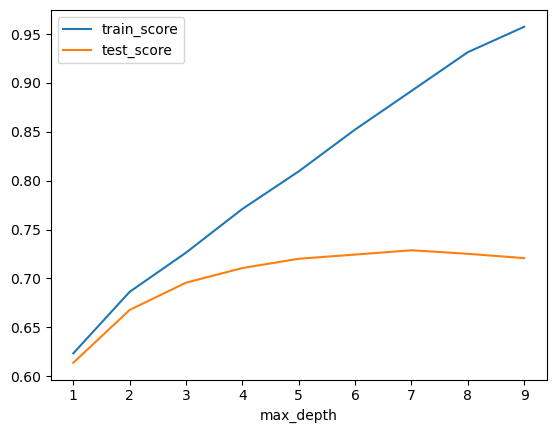

In [555]:
# Plot the results
models_df.plot()

###Results #balanced accuracy score max depth for testing data
* dfx_GradientBoostingClassifier:  Nosample: 2-4 .63-.67  |  Uresampled: 2-3  .67 - 70  |  Oversampled: 2-4  .67 - .71  | smote,teen,tomek,adasyn NA
* train_dum_df: Nosample: 3-4 .67 - .68  |  Uresampled: 3-4, .70 - .71  |  Oversampled: 3-4  .70 - .71

* dfx_RandomForestClassifier: Nosample 5-7 .58 - .64  |  Uresampled: 4-6  .64 - .66 |  Oversampled: 4 - 6 .64 - .66
* train_dum_df: Nosample: 5-6, .61-62  |  Uresampled:5-6, .65-.66   |  Oversampled: 5-6, .65 - .66 


* dfx_ExtraTreesClassifier: Nosample: 4-7, .64-.67|  Uresampled: 5-8, .61 - .63 |  Oversampled: 6-8, .62-.63
* train_dum_df: Nosample: 7-8 .56 - .58 |  Uresampled: 5-6, .60-.62  |  Oversampled: 6-7, .62- .63

* dfx_XGBClassifier: Nosample: 2-3, .67 - .68 |  Uresampled: 2- 3, .69 - .72  |  Oversampled: 2-3, .69-.73
* train_dum_df: Nosample: 6-8, .55 - .58 |  Uresampled: 2-3, .69- .71   |  Oversampled: 2-3, .70-.71

* dfx_LGBMClassifier: Nosample: 2-4 .63 - .675 |  Uresampled: 3, .70  |  Oversampled: 3-4, .70 - .71
* train_dum_df: Nosample: 3-4, .70-.72 |  Uresampled: 3-4, .70- .72   |  Oversampled: 3-4, .70 - .72


In [247]:
param_grid = {
    'n_estimators': [ 200, 400, 600],
    'max_depth': [5,6,7],
    'min_samples_split': [4,6,8,10],
    'min_samples_leaf': [2,3,4,6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}


# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=13)


#feature selection:
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
X_train_selected = selector.fit_transform(X_train_Uresampled, y_train_Uresampled)
X_test_selected = selector.transform(X_test)

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=100, cv=10, n_jobs=-1, verbose=3, random_state=13, scoring = 'balanced_accuracy')



# Fit the grid search to the data
random_search.fit(X_train_selected, y_train_Uresampled)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_selected)



Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 7, 'class_weight': 'balanced', 'bootstrap': True}
Best Score: 0.7060589161406406


In [248]:
print(f'Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))

print(f'Training Score: {best_rf.score(X_train_selected, y_train_Uresampled)}')
print(f'Testing Score: {best_rf.score(X_test_selected, y_test)}')

Balanced accuracy score: 0.7073483236062275
              precision    recall  f1-score   support

           0       0.82      0.64      0.71      3774
           1       0.58      0.78      0.67      2456

    accuracy                           0.69      6230
   macro avg       0.70      0.71      0.69      6230
weighted avg       0.72      0.69      0.70      6230

Training Score: 0.7420252477263473
Testing Score: 0.6922953451043339


In [ ]:
#Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [4,5,6,7], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at each leaf node
    'max_features': [None, 'sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
}

# Create the RandomForestClassifier model
rf_model_grid = RandomForestClassifier(random_state=13)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


In [ ]:
# Feature importance
best_rf = random_search.best_estimator_
importances = best_rf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)


In [178]:
# Create the RandomForestClassifier model
rf_model_grid = RandomForestClassifier(random_state=13,
                                   n_estimators= 400,
                                    min_samples_split=6,
                                    min_samples_leaf= 1,
                                    max_features= None,
                                    max_depth=5,
                                    bootstrap=True,
                                    )

#fit the model
rf_model_grid.fit(X_train_Uresampled,y_train_Uresampled)

#predict
y_pred_rf_grid = rf_model_grid.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred_rf_grid))

0.6820391837516766


All these scores are from train_dum_df
* oversampler: 0.7031507580583074  (max_depth = 7)
* max_depth = 6: 0.6952886973963809
* max_depth = 5: 0.6850869958864785
* max_depth = 4: 0.666400940603374
* max_depth = 6: 0.6783363886975691  (no sampler)
* max_depth = 6: 0.6874197319565206 w/ undersampler

In [198]:
# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=13,
                                   n_estimators= 400,
                                    min_samples_split=10,
                                    min_samples_leaf= 3,
                                    max_features=None,
                                    max_depth=6,
                                    bootstrap=True,
                                    class_weight= 'balanced'
                                    )

#fit the model
rf_model.fit(X_train_Uresampled,y_train_Uresampled)

#predict
y_pred_rf = rf_model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred_rf))

0.6870836634680283


In [199]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_pred_rf, y_test))

display(f'Training Score: {rf_model.score(X_train_Uresampled, y_train_Uresampled)}')
display(f'Testing Score: {rf_model.score(X_test, y_test)}')


'balanced accuracy score: 0.6870836634680283'

              precision    recall  f1-score   support

           0       0.64      0.79      0.71      3066
           1       0.73      0.57      0.64      3164

    accuracy                           0.68      6230
   macro avg       0.69      0.68      0.67      6230
weighted avg       0.69      0.68      0.67      6230



'Training Score: 0.7100583683996199'

'Testing Score: 0.6770465489566613'

original: 
'balanced accuracy score: 0.625125364874359'
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4790
           1       0.38      0.65      0.48      1440

    accuracy                           0.68      6230
   macro avg       0.63      0.67      0.62      6230
weighted avg       0.76      0.68      0.70      6230

'Training Score: 0.702857448630137''Testing Score: 0.6764044943820224'

added problem_id, month, year, day_of_week & oversampler max depth=7:
'balanced accuracy score: 0.702255618331495'
              precision    recall  f1-score   support

           0       0.63      0.81      0.71      2937
           1       0.77      0.58      0.66      3293

    accuracy                           0.69      6230
   macro avg       0.70      0.69      0.69      6230
weighted avg       0.71      0.69      0.68      6230

'Training Score: 0.7307658334069429'
'Testing Score: 0.6871589085072232'

no problem id, no scaler, no sampler: max depth= 6
'balanced accuracy score: 0.6654581147539569'
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      3334
           1       0.67      0.56      0.61      2896

    accuracy                           0.67      6230
   macro avg       0.67      0.66      0.66      6230
weighted avg       0.67      0.67      0.66      6230

'Training Score: 0.6800620719178082'
'Testing Score: 0.6654895666131622'


In [179]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_rf_grid)}')
print(classification_report(y_pred_rf_grid, y_test))

display(f'Training Score: {rf_model_grid.score(X_train_Uresampled, y_train_Uresampled)}')
display(f'Testing Score: {rf_model_grid.score(X_test, y_test)}')


'balanced accuracy score: 0.6820391837516766'

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      3137
           1       0.72      0.57      0.63      3093

    accuracy                           0.67      6230
   macro avg       0.68      0.67      0.67      6230
weighted avg       0.68      0.67      0.67      6230



'Training Score: 0.6969594136011945'

'Testing Score: 0.6746388443017657'

original: 
'balanced accuracy score: 0.627274261231916'
              precision    recall  f1-score   support

           0       0.87      0.68      0.77      4791
           1       0.39      0.66      0.49      1439

    accuracy                           0.68      6230
   macro avg       0.63      0.67      0.63      6230
weighted avg       0.76      0.68      0.70      6230

'Training Score: 0.703392551369863'
'Testing Score: 0.6784911717495987'

added: month, year, day_of_week, no problem id &  no oversampled: max depth =6

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      4040
           1       0.57      0.64      0.60      2190

    accuracy                           0.70      6230
   macro avg       0.68      0.69      0.68      6230
weighted avg       0.71      0.70      0.71      6230
  Training Score: 0.7214790239726028'
  'Testing Score: 0.7017656500802568'

same: max_depth =5:
'balanced accuracy score: 0.6546975577800448'
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      4341
           1       0.49      0.64      0.55      1889

    accuracy                           0.69      6230
   macro avg       0.65      0.67      0.66      6230
weighted avg       0.72      0.69      0.70      6230

'Training Score: 0.7008775684931506'
'Testing Score: 0.6894060995184591'

undersampled: max depth: 5
balanced accuracy score: 0.6820391837516766'
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      3137
           1       0.72      0.57      0.63      3093

    accuracy                           0.67      6230
   macro avg       0.68      0.67      0.67      6230
weighted avg       0.68      0.67      0.67      6230

'Training Score: 0.6969594136011945'
'Testing Score: 0.6746388443017657'



In [145]:

xgb_model = XGBClassifier(random_state=13)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2,3,5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

xgb_random.fit(X_train, y_train)

print("Best parameters:", xgb_random.best_params_)
print("Best cross-validation score:", xgb_random.best_score_)

y_pred_xgb = xgb_random.predict(X_test)
print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_xgb))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Best cross-validation score: 0.7494122233259206
Balanced accuracy score: 0.7266691869106124


In [146]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_xgb)}')
print(classification_report(y_pred_xgb, y_test))

display(f'Training Score: {xgb_random.score(X_train, y_train)}')
display(f'Testing Score: {xgb_random.score(X_test, y_test)}')


'balanced accuracy score: 0.7266691869106124'

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      3933
           1       0.64      0.69      0.66      2297

    accuracy                           0.74      6230
   macro avg       0.73      0.73      0.73      6230
weighted avg       0.75      0.74      0.75      6230



'Training Score: 0.8581977739726028'

'Testing Score: 0.7443017656500802'

In [625]:


lgb_model = LGBMClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2],
    'learning_rate': [0.01,0.08, 0.09, 0.1],
    'num_leaves': [14,31, 62],
    'subsample': [.06, 0.8, 0.9]
}

lgb_random = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, 
                                n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

lgb_random.fit(X_train, y_train)

print("Best parameters:", lgb_random.best_params_)
print("Best cross-validation score:", lgb_random.best_score_)

y_pred_lgb = lgb_random.predict(X_test)
print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_lgb))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7367, number of negative: 11321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 18688, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394210 -> initscore=-0.429649
[LightGBM] [Info] Start training from score -0.429649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [163]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_lgb)}')
print(classification_report(y_pred_lgb, y_test))

display(f'Training Score: {lgb_random.score(X_train, y_train)}')
display(f'Testing Score: {lgb_random.score(X_test, y_test)}')

'balanced accuracy score: 0.6993824755009848'

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      4105
           1       0.58      0.67      0.62      2125

    accuracy                           0.72      6230
   macro avg       0.70      0.71      0.70      6230
weighted avg       0.74      0.72      0.73      6230



'Training Score: 0.7598994006849316'

'Testing Score: 0.7240770465489567'

In [355]:
# Train the ExtraTreesClassifier model
clf = ExtraTreesClassifier(random_state=1, max_depth=7).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 0.656785102739726
Testing Score: 0.6425361155698235


In [346]:
# Train the Gradient Boosting classifier
clf = GradientBoostingClassifier(random_state=1).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 0.720783390410959
Testing Score: 0.6980738362760834


In [347]:
# Train the AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

c:\Users\tyzwh\OneDrive\AI\bootcamp\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Score: 0.6784032534246576
Testing Score: 0.669983948635634


In [675]:


# Define the parameter grid for GradientBoostingClassifier
param_grid_gb = {
    'n_estimators': [ 200, 300, 400],
    'learning_rate': [  0.05, 0.08, 0.09, 0.1],
    'max_depth': [2],
    'min_samples_split': [ 4, 6, 8, 10],
    'min_samples_leaf': [2, 3, 4, 6],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['sqrt', 'log2', None]
}

# Create the GradientBoostingClassifier model
gb_model = GradientBoostingClassifier(random_state=13)

# Feature selection with RandomForest
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=13))
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test)

# set up Stratified K-Fold Cross-Validation for RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# Randomized search on GradientBoostingClassifier
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb, 
                                      n_iter=100, cv=cv, n_jobs=-1, verbose=3, random_state=13, scoring='balanced_accuracy')

# Fit the randomized search to the data
random_search_gb.fit(X_train_selected, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters (GB):", random_search_gb.best_params_)
print("Best Score (GB):", random_search_gb.best_score_)

# Use the best estimator for predictions
best_gb = random_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_selected)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters (GB): {'subsample': 0.7, 'n_estimators': 400, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 2, 'learning_rate': 0.09}
Best Score (GB): 0.7110688655917754


In [676]:
# Get the feature importance array
importances = best_gb.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(best_gb.feature_importances_, X.columns), reverse=True)
importances_sorted

[(0.24095701024414767, 'impact'),
 (0.2308786098331823, 'u_symptom'),
 (0.19890894960193345, 'year'),
 (0.09678726679574028, 'day_of_week'),
 (0.05877485197550083, 'month'),
 (0.0399335324636258, 'opened_by'),
 (0.03967711595770779, 'location'),
 (0.03966994552079917, 'subcategory'),
 (0.028691339271730565, 'category'),
 (0.02572137833563209, 'caller_id')]

In [512]:
# Evalate the model
print(f'Training Score: {best_gb.score(X_train_selected, y_train_resampled)}')
print(f'Testing Score: {best_gb.score(X_test_selected, y_test)}')

Training Score: 0.7312958219238583
Testing Score: 0.7040128410914928


In [513]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_gb)}')
print(classification_report(y_pred_gb, y_test))


'balanced accuracy score: 0.7067106026317561'

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      3308
           1       0.72      0.60      0.66      2922

    accuracy                           0.70      6230
   macro avg       0.71      0.70      0.70      6230
weighted avg       0.71      0.70      0.70      6230



###Gradiantbooster: uresample
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters (GB): {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 4, 'learning_rate': 0.1}
Best Score (GB): 0.7326584537044457
Training Score: 0.8250984118365685
Testing Score: 0.7226324237560192

'balanced accuracy score: 0.7291886756463304'
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      3224
           1       0.76      0.62      0.68      3006

###Gradiantbooster: uresample
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters (GB): {'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}
Best Score (GB): 0.7271667232021709
Training Score: 0.7849871046558979
Testing Score: 0.7242375601926164

balanced accuracy score: 0.7294470653830685'
              precision    recall  f1-score   support

           0       0.70      0.81      0.76      3264
           1       0.75      0.62      0.68      2966


param_grid_gb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [2,3,],
    'min_samples_split': [ 4, 6, 8, 10],
    'min_samples_leaf': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['sqrt', 'log2', None]
}

oversampled:
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters (GB): {'subsample': 0.9, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}
Best Score (GB): 0.736993716799663

Training Score: 0.7618584930659835
Testing Score: 0.7211878009630819

balanced accuracy score: 0.7249391084895971'
              precision    recall  f1-score   support

           0       0.71      0.81      0.75      3301
           1       0.74      0.62      0.68      2929


param_grid_gb = {
    'n_estimators': [ 200, 300, 400],
    'learning_rate': [  0.05, 0.08, 0.09, 0.1],
    'max_depth': [2,3],
    'min_samples_split': [ 4, 6, 8, 10],
    'min_samples_leaf': [2, 3, 4, 6],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['sqrt', 'log2', None]
}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters (GB): {'subsample': 0.7, 'n_estimators': 400, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}
Best Score (GB): 0.7433092979955651
Training Score: 0.7748873774401555
Testing Score: 0.7285714285714285

balanced accuracy score: 0.7326686837249206
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      3301
           1       0.75      0.63      0.69      2929



param_grid_gb = {
    'n_estimators': [ 200, 300, 400,500],
    'learning_rate': [  0.05, 0.08, 0.09, 0.1],
    'max_depth': [2],
    'min_samples_split': [ 4, 6, 8, 10],
    'min_samples_leaf': [2, 3, 4, 6],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['sqrt', 'log2', None]
}
Fitting 5 folds for each of 100 candidates, totalling 500 fits (10 folds give the same results)
Best Parameters (GB): {'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 2, 'learning_rate': 0.09}
Best Score (GB): 0.7171196928213168

Training Score: 0.7312958219238583
Testing Score: 0.7040128410914928

balanced accuracy score: 0.7067106026317561'
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      3308
           1       0.72      0.60      0.66      2922




In [487]:
# Import necessary libraries

from sklearn.tree import DecisionTreeClassifier


# Define the parameter grid for AdaBoostClassifier
param_grid_ab = {
    'n_estimators': [50, 100, 200, 400, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'],
    'estimator': [
        DecisionTreeClassifier(max_depth=1), 
        DecisionTreeClassifier(max_depth=2), 
        DecisionTreeClassifier(max_depth=3)
    ]
}

# Create the AdaBoostClassifier model
ab_model = AdaBoostClassifier(random_state=13)

# set up Stratified K-Fold Cross-Validation for RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# Set up RandomizedSearchCV
random_search_ab = RandomizedSearchCV(
    estimator=ab_model,
    param_distributions=param_grid_ab, 
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    verbose=3,
    random_state=13,
    scoring='balanced_accuracy'
)

# Fit the grid search to the data
random_search_ab.fit(X_train_selected, y_train_Uresampled)

# Print the best parameters and the best score
print("Best Parameters:", random_search_ab.best_params_)
print("Best Score:", random_search_ab.best_score_)

# Use the best estimator to make predictions
best_ab = random_search_ab.best_estimator_
y_pred_ab = best_ab.predict(X_test_selected)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


c:\Users\tyzwh\OneDrive\AI\bootcamp\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3), 'algorithm': 'SAMME.R'}
Best Score: 0.7216027078048493


In [488]:
# Evalate the model
print(f'Training Score: {best_ab.score(X_train_selected, y_train_Uresampled)}')
print(f'Testing Score: {best_ab.score(X_test_selected, y_test)}')

Training Score: 0.7896701506719153
Testing Score: 0.7182985553772071


In [489]:
display(f'balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_ab)}')
print(classification_report(y_pred_ab, y_test))


'balanced accuracy score: 0.7222699802695971'

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      3291
           1       0.74      0.62      0.67      2939

    accuracy                           0.72      6230
   macro avg       0.72      0.71      0.71      6230
weighted avg       0.72      0.72      0.72      6230



In [672]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

# Step 1: Define your estimator
estimator = GradientBoostingClassifier(random_state=13)

# Step 2: Set up StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# Step 3: Initialize RFECV
rfecv = RFECV(
    estimator=estimator, 
    step=1, 
    cv=cv, 
    scoring='balanced_accuracy', 
    n_jobs=-1
)

# Step 4: Fit RFECV to your training data
rfecv.fit(X_train_resampled, y_train_resampled)

# Step 5: Transform the data using the selected features
X_train_selected = rfecv.transform(X_train_resampled)
X_test_selected = rfecv.transform(X_test)

# Print the number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

# Print the selected features
print(f"Selected features: {rfecv.support_}")

# You can then use the selected features for further model training
best_ft = GradientBoostingClassifier(random_state=13)
best_ft.fit(X_train_selected, y_train_resampled)
y_pred_gb = best_ft.predict(X_test_selected)

# Evaluate the model
print(f'Training Score: {best_ft.score(X_train_selected, y_train_resampled)}')
print(f'Testing Score: {best_ft.score(X_test_selected, y_test)}')
print(f'Balanced accuracy score: {balanced_accuracy_score(y_test, y_pred_gb)}')
print(classification_report(y_test, y_pred_gb))


Optimal number of features: 7
Selected features: [False False  True  True  True False  True False  True False False False
  True  True False False False False False False False False False False
 False False]
Training Score: 0.7181344404204576
Testing Score: 0.6926163723916533
Balanced accuracy score: 0.6995792616720955
              precision    recall  f1-score   support

           0       0.79      0.67      0.72      3774
           1       0.59      0.73      0.65      2456

    accuracy                           0.69      6230
   macro avg       0.69      0.70      0.69      6230
weighted avg       0.71      0.69      0.70      6230



In [674]:
# Get the feature importance array
importances = best_ft.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(best_ft.feature_importances_, X.columns), reverse=True)
importances_sorted

[(0.28705109046257615, 'category'),
 (0.24683512870916816, 'location'),
 (0.23380132109828397, 'caller_id'),
 (0.09769831391403482, 'month'),
 (0.06037330421241872, 'year'),
 (0.04342458437620149, 'day_of_week'),
 (0.03081625722731667, 'opened_by')]

In [622]:
dfx.columns

Index(['caller_id', 'year', 'month', 'day_of_week', 'opened_by', 'location',
       'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'contact_type_Email', 'contact_type_IVR',
       'contact_type_Phone', 'contact_type_Self service', 'notify_Send Email',
       'rfc', 'cmdb_ci', 'vendor', 'caused_by', 'problem_id'],
      dtype='object')